In [20]:
using Pkg

In [21]:
using DifferentialEquations

In [22]:
using Plots

In [4]:
#Pkg.add("Images")

In [5]:
#using Images

# Example

# High Power Rocket

In [23]:
function Rflag(R)
    if R < R0 - 10
        return 0
    else
        return 1
    end
end

Rflag (generic function with 1 method)

In [24]:
function amibent(h)
    if h < 11000
        T = 15.04 - 0.00649*h
        p = 101.29 * ((T+273.1)/(288.08))^(5.256)
    elseif 11000 <= h < 25000
        T = -56.46 
        p = 22.65 * exp(1.73-0.000157*h)
    elseif h >= 25000
        T = -131.21 + 0.00299*h 
        p = 2.488 * ((T+273.1)/216.6)^(-11.388)
    end  
    rho = p/(0.2869*(T+273.1))
    #return p * 1000,rho,T
    return rho
end

amibent (generic function with 1 method)

In [25]:
## return immediate thrust 
function Thrust(t)
    if -10 < t < t_inject_1
        return T1
    elseif t_inject_1 <= t < t_inject_2
        return T2
    else
        return 0.0
    end
end

Thrust (generic function with 1 method)

In [26]:
## return the exhaust mass flow rate
function Mass_Flow(t)
    if t < t_inject_1
        return mass_flow * 4.0
    elseif t_inject_1 <= t < t_inject_2
        return mass_flow
    else
        return 0.0
    end
end

Mass_Flow (generic function with 1 method)

## Falcon 1 Merlin 1A rocket engine, full-thrust version

## Falcon 9 Merlin 1D rocket engine, full-thrust version

In [40]:
##launch parameter
m_rocket = 33800.0
m_fuel1 = 367500.0
m_fuel2 = 140000.0

t_inject_1 = 330.0
t_inject_2 = 660.0

v_limit1 = 80.0
v_limit2 = 360.0
v_limit3 = 6000.0

p_e = 9.7 * 1000000

##engine parameter
mass_flow = 273.6
##Area_chamber = pi * 0.92^2 
##u_e = 3413
T1 = 6806000
T2 = 934000
##earth parameter
R0 = 6400000.0

k_aero = 3.7^2 * 0.25 * 1/2

## motion parameter
v_0 = 10.0

theta0 = deg2rad(90 - 6)

1.4660765716752369

In [41]:
## keep filght trajectory when the speed is low 
function theta_delay(v)
    if v < v_limit1
        return 0.0
    elseif v_limit1 <= v < v_limit2
        k = 1 + exp((v_limit1 + v_limit2)/2-v)
       return (1/k)
    elseif v_limit2 <= v < v_limit3
       k = 1
        return (1/k)
    else
        return 1
    end
end

theta_delay (generic function with 1 method)

$$
\left\{\begin{array}{l}
R^{\prime}=\nu \sin \theta \\
\varphi^{\prime}=\nu \frac{\cos \theta}{R} \\
a_{1}=\frac{T}{m} \\
a_{2}=-\frac{k_{\text {areo }} \rho v^{2}}{m} \\
a_{3}=-g \cos \theta \\
v^{\prime}=a_{1}+a_{2}+a_{3} \\
\theta^{\prime}=\frac{g \sin \theta}{\nu}-\frac{v \sin \theta}{r} \\
m^{\prime}=-m_{\text {mass_rate }}
\end{array}\right.
$$

In [42]:
function line1!(du,u,p,t)
    du[1] = Rflag(u[1]) * u[3] * sin(u[4])
    du[2] = Rflag(u[1]) * u[3] * cos(u[4])/u[1]
    a1 =  1*Thrust(t)./(u[5])
    #a2 = - k_aero .*(amibent(u[1] - R0)[2] .* u[3]^2)./(u[5])
    a2 = - k_aero .*(amibent(u[1] - R0) .* u[3]^2)./(u[5])
    a3 = - 9.8 * (R0/u[1])^2 *sin(u[4])
    du[3] =  a1 + a2 + a3
    du[4] = theta_delay(u[3]) *((u[3] * cos(u[4]))/u[1] - (9.8 * (R0/u[1])^2) * cos(u[4])/u[3])
    du[5] = - Mass_Flow(t)
end

line1! (generic function with 1 method)

In [43]:
m = m_fuel1 + m_fuel2 + m_rocket
u0 = [R0;0.0;v_0;theta0;m]
tspan = (0.0,t_inject_1)
prob = ODEProblem(line1!,u0,tspan)
sol1 = solve(prob,DP5(),dt=0.0001)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 13-element Array{Float64,1}:
   0.0
   0.0001
   0.0011
   0.0111
   0.11109999999999999
   1.1111
  11.111099999999999
  55.50440668562353
 128.1207376347329
 186.57455894113752
 281.03886133741946
 317.6249320979197
 330.0
u: 13-element Array{Array{Float64,1},1}:
 [6.4e6, 0.0, 10.0, 1.4660765716752369, 541300.0]
 [6.400000000994536e6, 1.6332803223393252e-11, 10.000282673323365, 1.4660765716752369, 541299.89056]
 [6.400000010941442e6, 1.7968622770085225e-10, 10.003109420434408, 1.4660765716752369, 541298.79616]
 [6.400000110565123e6, 1.8157597806464917e-9, 10.031378279293925, 1.4660765716752369, 541287.85216]
 [6.4000011222694665e6, 1.8430509949589397e-8, 10.314205652369099, 1.4660765716752369, 541178.4121600001]
 [6.400012791175357e6, 2.10063337582513e-7, 13.156367346952944, 1.4660765716752369, 540084.01216]
 [6.400289801229567e6, 4.759163595689393e-6, 42.97586861749559, 1.4660765716752369, 529140.01216]
 [

In [44]:
u0 = last(sol1) 
u0[5] = m_rocket + m_fuel2

tspan = (t_inject_1,t_inject_2)
prob = ODEProblem(line1!,u0,tspan)
sol2 = solve(prob,OwrenZen3(),dt=0.0001)

retcode: Success
Interpolation: specialized 3rd order "free" interpolation
t: 22-element Array{Float64,1}:
 330.0
 330.0001
 330.00109999999995
 330.01109999999994
 330.11109999999996
 331.11109999999996
 335.7122739938118
 343.02196851852045
 353.35026227598786
 367.1609330224632
 384.4574172683317
 405.1601028346196
 428.86348314904524
 455.0006728521689
 482.77704611045004
 511.2160793174623
 539.1164263671003
 564.9495867174552
 586.1279333905331
 610.6612624320662
 635.4223227994752
 660.0
u: 22-element Array{Array{Float64,1},1}:
 [6.605693516668505e6, 0.06379814241591546, 4649.318190770442, 0.21435299863479376, 173800.0]
 [6.6056936155665815e6, 0.06379821118863595, 4649.318532489051, 0.21435287407485085, 173799.97264]
 [6.605694604544637e6, 0.06379889891616485, 4649.321949686271, 0.21435162847655737, 173799.69904]
 [6.605704494053944e6, 0.06380577622384888, 4649.356122771795, 0.21433917260717847, 173796.96304]
 [6.605803362023172e6, 0.06387455254065309, 4649.697964959008, 0.21421

In [37]:
u0 = last(sol2) 
u0[5] = m_rocket

tspan = (t_inject_2,1400)
prob = ODEProblem(line1!,u0,tspan)
sol3 = solve(prob, Euler() ,dt = 40)

retcode: Success
Interpolation: 3rd order Hermite
t: 18-element Array{Float64,1}:
  720.0
  760.0
  800.0
  840.0
  880.0
  920.0
  960.0
 1000.0
 1040.0
 1080.0
 1120.0
 1160.0
 1200.0
 1240.0
 1280.0
 1320.0
 1360.0
 1400.0
u: 18-element Array{Array{Float64,1},1}:
 [6.672142568859395e6, 0.40486501589948337, 7755.726641053371, -0.05222389288018193, 33800.0]
 [6.6559485627897605e6, 0.45129779357073074, 7774.553853767669, -0.05223198911744367, 33800.0]
 [6.63971273102928e6, 0.49795651394720203, 7793.47567612334, -0.05212736906433406, 33800.0]
 [6.623469954029129e6, 0.5448434196240635, 7812.452003108973, -0.051909188535242255, 33800.0]
 [6.607255716277321e6, 0.5919602864334077, 7831.441567251722, -0.0515768367179493, 33800.0]
 [6.591106039328826e6, 0.6393084002569497, 7850.4019165787895, -0.05112994589149371, 33800.0]
 [6.575057409032403e6, 0.6868885336346583, 7869.289266737242, -0.050568401975219, 33800.0]
 [6.559146696788171e6, 0.7347009215299746, 7888.057979096217, -0.0498923574792953

In [46]:
u0 = last(sol2) 
u0[5] = m_rocket

tspan = (t_inject_2,10000)
prob = ODEProblem(line1!,u0,tspan)
sol4 = solve(prob, Euler() ,dt = 10)

retcode: Success
Interpolation: 3rd order Hermite
t: 935-element Array{Float64,1}:
   660.0
   670.0
   680.0
   690.0
   700.0
   710.0
   720.0
   730.0
   740.0
   750.0
   760.0
   770.0
   780.0
     ⋮
  9890.0
  9900.0
  9910.0
  9920.0
  9930.0
  9940.0
  9950.0
  9960.0
  9970.0
  9980.0
  9990.0
 10000.0
u: 935-element Array{Array{Float64,1},1}:
 [6.694121304838192e6, 0.338919221268236, 6981.7639502399925, -0.04488930771485129, 33800.0]
 [6.690988291778357e6, 0.34933840925753346, 6985.78366676496, -0.047287403410466396, 33800.0]
 [6.687686127056541e6, 0.35976732404188366, 6990.021936269735, -0.04967897813629542, 33800.0]
 [6.684214983795747e6, 0.3702065071724902, 6994.478783058408, -0.05206367899296597, 33800.0]
 [6.68057504575394e6, 0.38065650201969514, 6999.154231119999, -0.05444115321389318, 33800.0]
 [6.676766507441861e6, 0.39111785386602954, 7004.048304029944, -0.05681104816902769, 33800.0]
 [6.67278957424733e6, 0.40159110999945485, 7009.161024842699, -0.05917301136801056

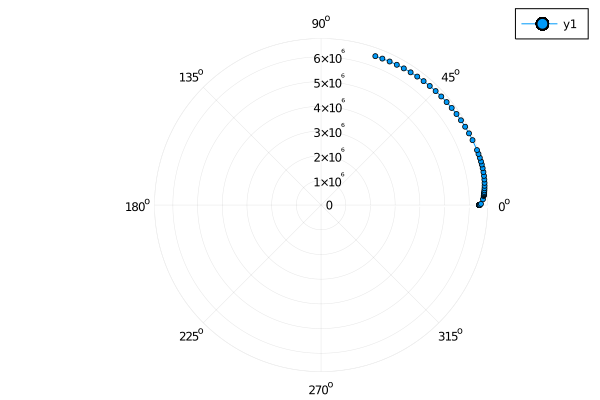

In [48]:
phi1 = sol1[2,:]
r1 = sol1[1,:]

phi2 = sol2[2,:]
r2 = sol2[1,:]

phi3 = sol3[2,:]
r3 = sol3[1,:]

phi = vcat(phi1, phi2,phi3)
r = vcat(r1,r2,r3)

#phi = vcat(phi1, phi2)
#r = vcat(r1,r2)

plot(phi,r,proj = :polar, m = 3)

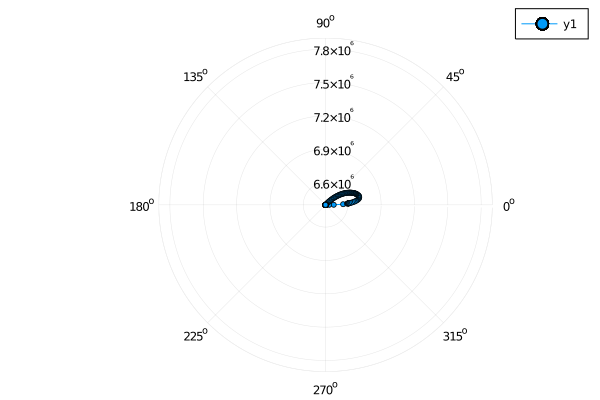

In [49]:
phi1 = sol1[2,:]
r1 = sol1[1,:]

phi2 = sol2[2,:]
r2 = sol2[1,:]

phi4 = sol4[2,:]
r4 = sol4[1,:]

launch_phi = vcat(phi1, phi2,phi4)
launch_r = vcat(r1,r2,r4)

plot(launch_phi,launch_r,proj = :polar, m = 3,ylims=(R0,R0+1500000))